In [1]:
%load_ext autoreload
%autoreload 2

# Audio data parsing

What does this notebook do
* convert all the audio files to 16kHz mono
* normalize the audio
* save the audio as a 32-bit float numpy array

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import torchaudio
from tqdm.auto import tqdm
import librosa
import noisereduce as nr

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir, speech_data_session_dir, interim_speech_data_dir
from sgs_utils.data_filtering import get_valid_audio_mask

from IPython.display import Audio, display

In [5]:
# Load the session data and only parse the valid sessions
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

df_session_v = df_session[
    get_valid_audio_mask(df_session)
    # TODO -> i do not find that we can already impose here a (strict) duration requirement
    # hence, this 5s only serves as a sanity check (and not as a hard requirement)
    & (df_session.wav_duration_s > 5.5)
]
print(f"{df_session.shape[0]} \ {df_session_v.shape[0]}")
del df_session


3257 \ 3005


## The parsing loop

### Without noise removal

In [6]:
import shutil 

SAVE_DIR_STR = 'full_dur_16khz_norm'

shutil.rmtree(interim_speech_data_dir / SAVE_DIR_STR)

for _, row in tqdm(df_session_v.iterrows(), total=len(df_session_v)):
    wav_path: Path = list(
        speech_data_session_dir.glob(
            f"*{row.ID}/{row.DB}/{row.pic_name}__{row.time_str}.wav"
        )
    )[0]

    # load and normalize the data
    arr, fs = torchaudio.load(wav_path, channels_first=True, normalize=True)

    # make sure that we convert the audio to mono
    arr = arr.mean(axis=0, keepdims=True)

    # resample the data if needed 
    if fs != 16_000:
        arr = torchaudio.functional.resample(arr, orig_freq=fs, new_freq=16_000)
        
    # normalize the audio
    arr_n = librosa.util.normalize(arr.numpy().ravel())

    save_dir = interim_speech_data_dir / SAVE_DIR_STR / row.ID / row.DB 
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # store the data as a numpy arr with dimensions [n_channels, channel_audio]
    # and as it is mono -> [1, channel_audio]
    np.save(file=save_dir / wav_path.stem, arr=arr_n.reshape(1, -1))

  0%|          | 0/3005 [00:00<?, ?it/s]

### With noise removal

In [7]:
import shutil 

SAVE_DIR_STR = 'full_dur_16khz_nr_norm'

if (interim_speech_data_dir / SAVE_DIR_STR).is_dir():
    shutil.rmtree(interim_speech_data_dir / SAVE_DIR_STR)

for _, row in tqdm(df_session_v.iterrows(), total=len(df_session_v)):
    wav_path: Path = list(
        speech_data_session_dir.glob(
            f"*{row.ID}/{row.DB}/{row.pic_name}__{row.time_str}.wav"
        )
    )[0]

    # load and normalize the data
    arr, fs = torchaudio.load(wav_path, channels_first=True, normalize=True)

    # make sure that we convert the audio to mono
    arr = arr.mean(axis=0, keepdims=True)

    # resample the data if needed 
    if fs != 16_000:
        arr = torchaudio.functional.resample(arr, orig_freq=fs, new_freq=16_000)
        
    # perform noise removal
    arr_nr = nr.reduce_noise(arr.numpy().ravel(), sr=16_000, stationary=True)
        
    # normalize the audio
    # Note that we perform audio normalization after noise removal.
    arr_n = librosa.util.normalize(arr_nr.ravel())

    save_dir = interim_speech_data_dir / SAVE_DIR_STR / row.ID / row.DB 
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # store the data as a numpy arr with dimensions [n_channels, channel_audio]
    # and as it is mono -> [1, channel_audio]
    np.save(file=save_dir / wav_path.stem, arr=arr_n.reshape(1, -1))

  0%|          | 0/3005 [00:00<?, ?it/s]

### Visualizing the effect of noise removal

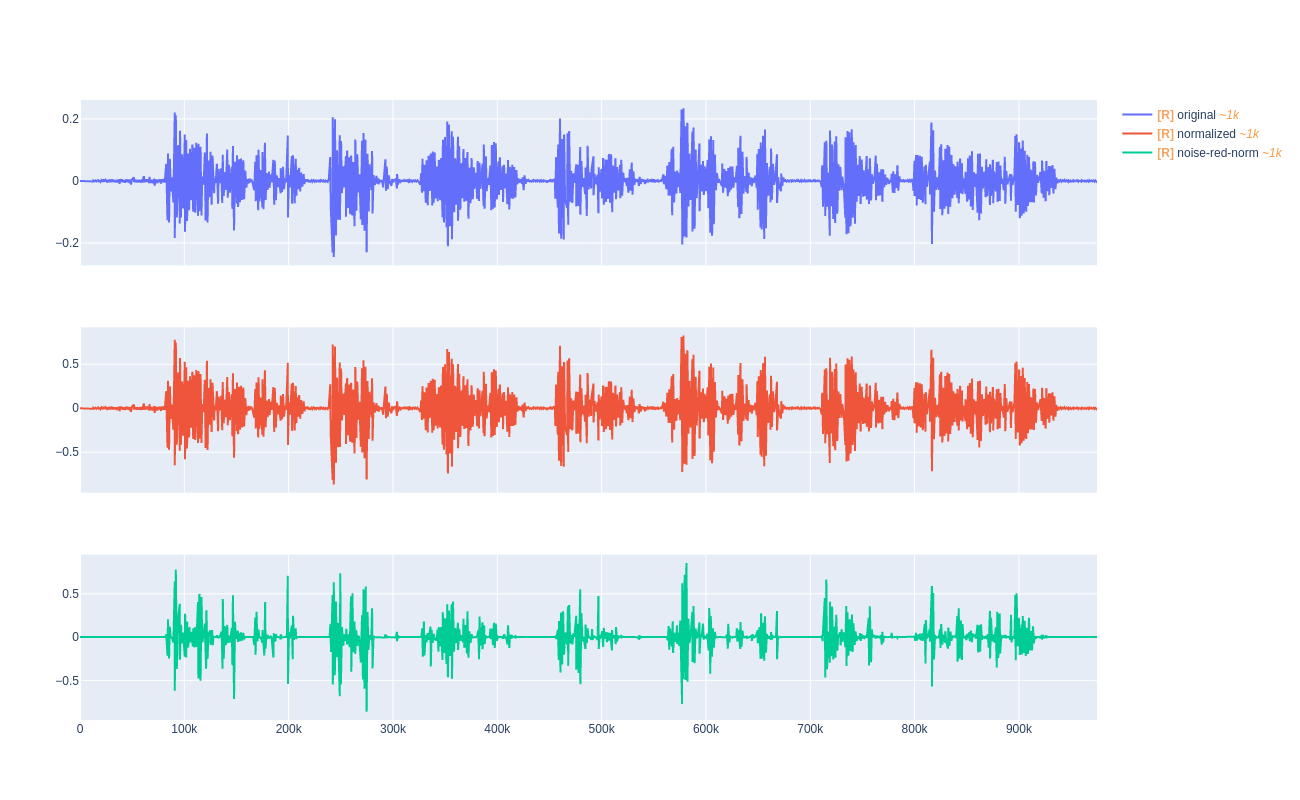

In [8]:
# Audio normalization testing code
from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots

arr, fs = torchaudio.load(wav_path, channels_first=True, normalize=True)
# make sure that we convert the audio to mono
arr = arr.mean(axis=0, keepdims=True)

fr = FigureResampler(make_subplots(rows=3, shared_xaxes=True))
fr.update_layout(height=800)
fr.add_trace({'name': 'original'}, hf_y=arr.numpy().ravel())
fr.add_trace({'name': 'normalized'}, hf_y=librosa.util.normalize(arr.numpy().ravel()), col=1, row=2)
fr.add_trace({'name': 'noise-red-norm'}, hf_y=librosa.util.normalize(nr.reduce_noise(arr.numpy().ravel(), sr=16_000, stationary=True)), col=1, row=3)
fr.show(renderer="png", width=1300)

--- 

In [16]:
# Example / testing code for resampling + normalization

arr, fs = torchaudio.load(wav_path, channels_first=True, normalize=True)
# make sure that we convert the audio to mono
arr = arr.mean(axis=0, keepdims=True)

if fs != 16_000:
    arr = torchaudio.functional.resample(arr, orig_freq=fs, new_freq=16_000)

# perform noise removal
arr_nr = nr.reduce_noise(arr.numpy().ravel(), sr=16_000, stationary=True)
arr_nr_ns = nr.reduce_noise(arr.numpy().ravel(), sr=16_000, stationary=False)

arr = librosa.util.normalize(arr.numpy().ravel())
arr_nr = librosa.util.normalize(arr_nr.ravel())
print("resampled + normalized:")
display(Audio(data=arr[2 * 16_000 : 16_000 * 7], rate=16_000, autoplay=False))
print("resampled + stationary noise reduction + normalized:")
display(Audio(data=arr_nr[2 * 16_000 : 16_000 * 7], rate=16_000, autoplay=False))
print("resampled + non-stationary noise reduction + normalized:")
display(Audio(data=arr_nr_ns[2 * 16_000 : 16_000 * 7], rate=16_000, autoplay=False))

resampled + normalized:


resampled + stationary noise reduction + normalized:


resampled + non-stationary noise reduction + normalized:


**Notes**:
It seems that there is little to no added value of performing this noise-removal. the speech samples sound way less natural, and this imposes additional complexity with (little to) no gain in speech data quality